In [780]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [781]:
import warnings
warnings.filterwarnings('ignore')

In [782]:
matplotlib.rcParams.update({'font.size': 14})

In [783]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### 1. Загрузка данных

In [784]:
#TRAIN_DATASET_PATH = './realestatepriceprediction/train.csv'
#TEST_DATASET_PATH = './realestatepriceprediction/test.csv'

In [785]:
TRAIN_DATASET_PATH = 'C:/Users/Alena/Documents/PyLib/train.csv'
TEST_DATASET_PATH = 'C:/Users/Alena/Documents/PyLib/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры


In [786]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [787]:
train_df.shape

(10000, 20)

In [788]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [789]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [790]:
test_df.shape

(5000, 19)

In [791]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

#### 1.2 Приведение данных

In [792]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [793]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 2. EDA: визуализация данных

#### 2.1 Распределение целевой переменной

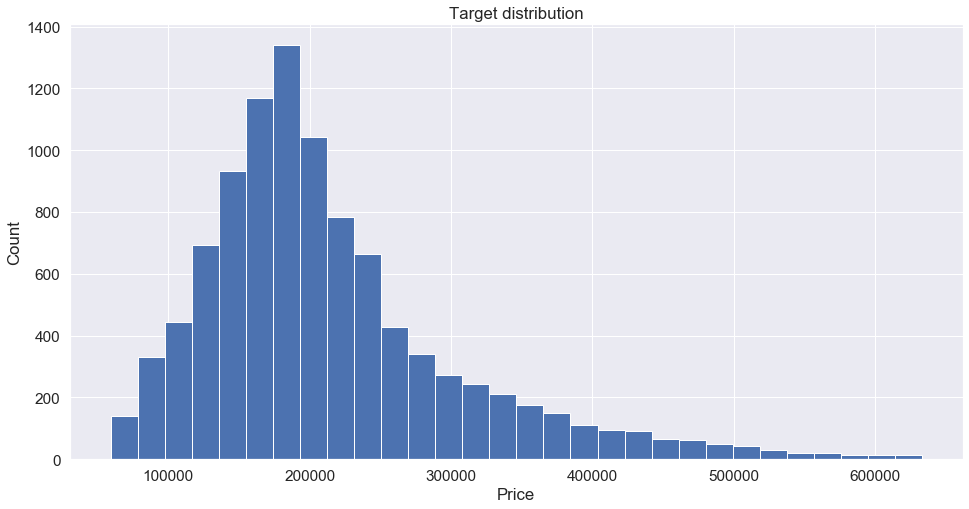

In [726]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### 2.2 Анализ признаков

#### Количественные признаки

In [727]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int64', 'int32', 'int16', 'int8'])
train_df_num_features.drop('Price', axis=1, inplace=True)

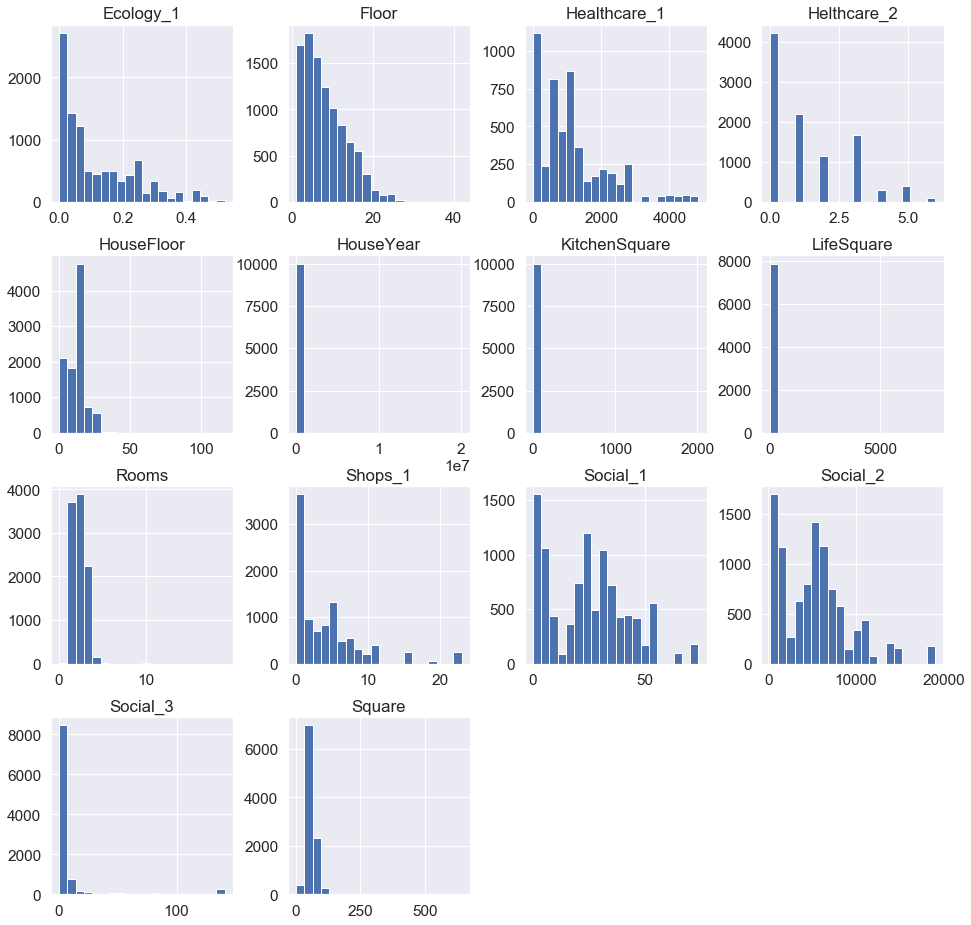

In [728]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=True);

#### Категориальные признаки

In [729]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [730]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
209      1
199      1
207      1
196      1
Name: DistrictId, Length: 205, dtype: int64

In [731]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [732]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [733]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Матрица корреляций
* Показывает линейную связь между переменными
* Изменяется от -1 до 1
* Коррелиция - мера только линейной связи

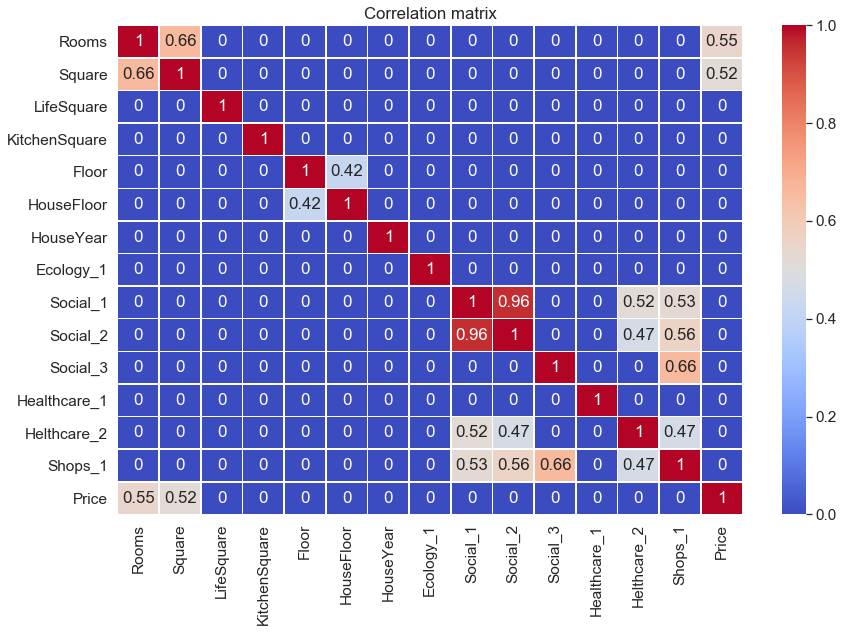

In [734]:
plt.figure(figsize = (14,9))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 3. Очистка данных и feature engineering

#### 3.1 Обработка выбросов

In [735]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


##### Признак 'Rooms'

Значения, которые равны 0, заменим единицей. Значения, которые больше 10, заменим медианой.

In [736]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [737]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [738]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### Признак 'Square'

Площади менее 12 кв.м заменим медианой

In [739]:
train_df['Square'].value_counts()

81.053044    1
54.002221    1
49.934561    1
53.317372    1
77.910891    1
            ..
57.134181    1
73.431719    1
46.049526    1
76.624790    1
97.664912    1
Name: Square, Length: 10000, dtype: int64

In [740]:
(train_df['Square'] < 12).sum()

12

In [741]:
train_df.loc[(train_df['Square']<12), 'Square'] = train_df['Square'].median()

In [742]:
(train_df['Square'] < 12).sum()

0

##### Признак 'LifeSquare'

In [743]:
train_df['LifeSquare'].value_counts()

35.812832    1
58.218079    1
35.213655    1
23.656629    1
4.289714     1
            ..
82.418226    1
43.005439    1
56.867287    1
87.018830    1
33.743934    1
Name: LifeSquare, Length: 7887, dtype: int64

In [744]:
(train_df['LifeSquare'] < 9).sum()

205

In [745]:
(train_df['LifeSquare'] > 600).sum()

2

In [746]:
train_df.loc[(train_df['LifeSquare'] < 9) | (train_df['LifeSquare'] > 600), 'LifeSquare'] = train_df['LifeSquare'].median()

In [747]:
((train_df['LifeSquare'] < 9) | (train_df['LifeSquare'] > 600)).sum()

0

##### Признак 'KitchenSquare'

Заменим значения менее 3 кв.м тремя квадратными метрами,
а более 100 кв.м - медианой

In [748]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [749]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [750]:
train_df.loc[train_df['KitchenSquare'] > 100, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [751]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
5.0     1169
10.0    1075
6.0     1043
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
22.0       3
37.0       2
30.0       2
43.0       2
25.0       2
51.0       2
58.0       2
32.0       2
41.0       2
48.0       1
72.0       1
96.0       1
36.0       1
40.0       1
78.0       1
66.0       1
35.0       1
84.0       1
62.0       1
42.0       1
63.0       1
39.0       1
60.0       1
26.0       1
21.0       1
29.0       1
23.0       1
73.0       1
27.0       1
31.0       1
53.0       1
75.0       1
54.0       1
Name: KitchenSquare, dtype: int64

##### Признак 'HouseFloor'

Заменим значения, которые равны 0 либо больше 93, медианой.

In [752]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [753]:
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 93), 'HouseFloor'] = train_df['HouseFloor'].median()

In [754]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48.])

##### Признак 'HouseYear'

Заменим значения года, которые больше 2020 года, на 2020.

In [755]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [756]:
train_df.loc[train_df['HouseYear']>2020, 'HouseYear'] = 2020

In [757]:
train_df['HouseYear'].sort_values().unique()

array([1910, 1912, 1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942,
       1947, 1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

#### 3.2 Удаление ненужных признаков

* Удалим признак 'Id'

In [758]:
train_df = train_df.drop('Id', axis=1)

* Удалим признак 'Social_2'

In [759]:
train_df = train_df.drop('Social_2', axis=1)

#### 3.3 Обработка пропусков

In [760]:
train_df.isna()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [761]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

* Признак **'Healthcare_1'** удаляем
* Признак **'LifeSquare'** - пропущенные значения заменяем медианой

In [762]:
train_df = train_df.drop('Healthcare_1', axis=1)

In [763]:
median = train_df['LifeSquare'].median()

In [764]:
train_df['LifeSquare'].fillna(median, inplace=True)

In [765]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,5,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,1,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,B,B,34,0,1,3,B,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,3,0,5,B,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,1,2,4,B,150226.531644


In [766]:
train_df.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

#### 3.4 Построение новых признаков

##### 'Dummies'

In [767]:
bin_to_num = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(bin_to_num)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(bin_to_num)
train_df['Shops_2'] = train_df['Shops_2'].replace(bin_to_num)

In [768]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,5,0,11,1,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,1,1,16,1,300009.450063
2,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,1,1,34,0,1,3,1,220925.908524
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,3,0,5,1,175616.227217
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,1,2,4,1,150226.531644


#### 3.5 Функция

In [794]:
class DataPreprocessing:

    def __init__(self):
        self.medians=None
        
    def fit(self, X):    
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):

        # Rooms     
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare   
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 100, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 93), 'HouseFloor'] = self.medians['HouseFloor']
        
        # HouseYear  
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # Id
        if 'Id' in X.columns:
            X.drop('Id', axis=1, inplace=True)
        
        # Social_2
        if 'Social_2' in X.columns:
            X.drop('Social_2', axis=1, inplace=True)      
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [795]:
class FeatureGenetator():
    
    def __init__(self):
        self.bin_to_num = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Dummies
        self.bin_to_num = {'A': 0, 'B': 1}
        
    def transform(self, X):
        
        # Dummies
        X['Ecology_2'] = X['Ecology_2'].map(self.bin_to_num)
        X['Ecology_3'] = X['Ecology_3'].map(self.bin_to_num)
        X['Shops_2'] = X['Shops_2'].map(self.bin_to_num)
    
        return X

In [796]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape

((10000, 17), (5000, 16))

In [797]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 17), (5000, 16))

In [798]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

In [799]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   int64  
 10  Ecology_3      5000 non-null   int64  
 11  Social_1       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  Shops_2        5000 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 625.1 KB


### 4. Отбор признаков

In [801]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [802]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_3', 'Helthcare_2', 
                 'Shops_1', 'Shops_2']

target_name = 'Price'

### 5. Разбиение на train и test

In [803]:
X = train_df[feature_names]
y = train_df[target_name]

test_df = test_df[feature_names]

In [804]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### 6. Построение модели

#### Обучение

In [805]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10,
                                 min_samples_leaf=20,
                                 random_state=21,
                                 n_estimators=20
                                 )

rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

#### Оценка модели

Train R2:	0.727
Test R2:	0.66


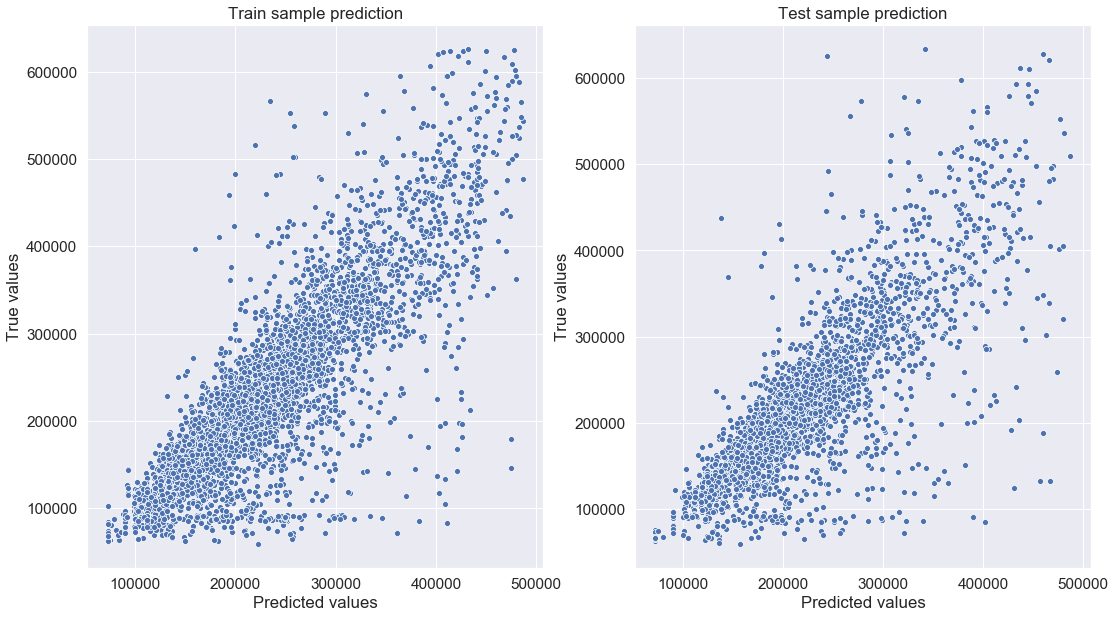

In [806]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Кросс-валидация

In [807]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.66840153, 0.67146138, 0.68933119])

In [808]:
cv_score.mean()

0.6763980358123197

### 7. Прогнозирование на тестовом датасете

In [809]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,1,0,0,1
1,2.0,69.263183,32.781260,3.0,6,1.0,1977,0.075779,1,1,6,3,0,2,1
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,87,5,5,1
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,3,3,3,1
4,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,1,1,2,1,0,0,0


In [810]:
submit = pd.read_csv('C:/Users/Alena/Documents/PyLib/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [811]:
predictions = rf_model.predict(test_df)
predictions

array([160929.74585834, 179770.09810197, 191466.63670777, ...,
       325998.5376538 , 202668.93107404, 183586.80003612])

In [812]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,160929.745858
1,15856,179770.098102
2,5480,191466.636708
3,15664,312104.939423
4,14275,133525.962859


In [813]:
submit.to_csv('rf_submit.csv', index=False)